# ChatGLM-6B加StableDiffusion实现类似文心一言多模态聊天效果

20230714 更新说明： 增加了ipywidget界面，方面大家使用

# 1. 简介 

## 文心一言
[文心一言](https://yiyan.baidu.com/)是一个百度推出的多模态聊天功能。可以根据用户的要求回复问题或者画一张画。

通过结合ChatGLM-6B及StableDiffusion，判断用户输入，如果需要画图则调用StableDiffusion画图，否则继续用ChatGLM聊天，实现类似文心一言多模态聊天功能。


## ChatGLM-6B

ChatGLM-6B 是一个开源的、支持中英双语的对话语言模型，基于 General Language Model (GLM) 架构，具有 62 亿参数。结合模型量化技术，用户可以在消费级的显卡上进行本地部署（INT4 量化级别下最低只需 6GB 显存）。 ChatGLM-6B 使用了和 ChatGPT 相似的技术，针对中文问答和对话进行了优化。经过约 1T 标识符的中英双语训练，辅以监督微调、反馈自助、人类反馈强化学习等技术的加持，62 亿参数的 ChatGLM-6B 已经能生成相当符合人类偏好的回答。

具体参考ChatGLM-6B的GitHub https://github.com/THUDM/ChatGLM-6B



## Stable Diffusion

Stable Diffusion是一种深度学习模型。Stable Diffusion主要用于文本生成图像 的深度学习模型，也就是常说的txt2img的应用场景中：通过给定 文本提示词（text prompt），该模型会输出一张匹配提示词的图片。具体可以参考我的文章：

深入浅出讲解Stable Diffusion原理，新手也能看明白
https://zhuanlan.zhihu.com/p/627133524


# 2.整体方案及运行效果

在AiStudio上整合ChatGLM，StableDiffusion，PaddleNLP，PPDiffuser等，仿照文心一言，开发了一个全功能的多模态聊天交互程序。可以根据Prompt聊天、画图等。

对于输入的Prompt为 ['画一幅画', '请画一幅画','画', 'draw a picture','draw','please draw'] 开头的内容调用画图程序，否则正常问答。画图的时候如果输入为中文则先用ChatGLM翻译成英文，形成Prompt，再进行画图。提供两种运行方案

## 命令行模式

效果如图：
![](https://ai-studio-static-online.cdn.bcebos.com/1104a15c41ea496990ed59f4bbccefd5e3651c15faec4357892c471d544d4d6d)

## ipywdiget界面模式

效果如图：
![](https://ai-studio-static-online.cdn.bcebos.com/e09866fb0e64405889299743f9ffdfe2e2e25b4bf2704439bad6428075645250)



具体说明可以参考我的文章：

ChatGLM-6B加StableDiffusion实现类似文心一言多模态聊天效果
https://zhuanlan.zhihu.com/p/634521615





# 3.模型安装 （安装后重启内核）



In [ ]:
# 更新环境
!pip install --pre --upgrade paddlenlp -f https://www.paddlepaddle.org.cn/whl/paddlenlp.html --user # 安装nlp分支最新包
!python -m pip install paddlepaddle-gpu==0.0.0.post112 -f https://www.paddlepaddle.org.cn/whl/linux/gpu/develop.html --user
!pip install -U ppdiffusers safetensors --user
#!unzip paddlenlp.zip
# 安装完记得重启内核

In [ ]:
#解压Stable Diffusion本地模型，也可以使用下载的模型
!tar -zxvf /home/aistudio/data/data202079/anything_v4.tar.gz

# 3 函数封装

封装了一些工具函数，和应用，最终集成为2个应用：

## 3.1 命令行模式

chat_with_glm(model,tokenizer,pipe,input_prompt,input_length=2048,output_length=256)

对于输入的Prompt为 ['画一幅画', '请画一幅画','画', 'draw a picture','draw','please draw'] 开头的内容调用画图程序，否则正常问答、

主要参数是：

model: ChatGLM模型

tokenizer：ChatGLM Token

pipe：StableDiffusion模型,

input_prompt：初始Prompt

input_length=2048,output_length=256

效果如图：

![](https://ai-studio-static-online.cdn.bcebos.com/d64203f36b6f4479a75df704f826f48fa2a0aef1e2194756bf72b74a9b593aa7)


## 3.2 widget模式

chat_glm_widgets(model,tokenizer,pipe)

显示ipywidgets界面，可以输入Prompt生成图片或者聊天。

对于输入的Prompt为 ['画一幅画', '请画一幅画','画', 'draw a picture','draw','please draw'] 开头的内容调用画图程序，否则正常问答、

主要参数是：

model: ChatGLM模型

tokenizer：ChatGLM Token

pipe：StableDiffusion模型,

效果如图：

![](https://ai-studio-static-online.cdn.bcebos.com/61382ab1e5cd43d7a747026a03995d8d07f13ae1ca924befb9777b94b65d3c7d)



In [1]:
import warnings 
import paddle
import os
import ipywidgets as widgets
from datetime import datetime
from IPython.display import clear_output as clear

warnings.filterwarnings("ignore")

#判断输入是否为中文
def is_chinese(text):
    for char in text:
        if not '\u4e00' <= char <= '\u9fff':
            return False
    return True

# 获取ChatGLM模型
def get_model(model_name_or_path):
    from paddlenlp.transformers import (
        ChatGLMConfig,
        ChatGLMForConditionalGeneration,
        ChatGLMTokenizer,
    )
    
    tokenizer = ChatGLMTokenizer.from_pretrained(model_name_or_path)
    config = ChatGLMConfig.from_pretrained(model_name_or_path)
    paddle.set_default_dtype(config.paddle_dtype)

    model = ChatGLMForConditionalGeneration.from_pretrained(
        model_name_or_path,
        tensor_parallel_degree=paddle.distributed.get_world_size(),
        tensor_parallel_rank=0,
        load_state_as_np=True,
        dtype=config.paddle_dtype,
    )

    model.eval()
    return model,tokenizer

def convert_example(example, tokenizer, is_test=True):
    query = example["user_input"]
    response = example["sys_output"]
    history = example.get("history", None)
    if history is None or len(history) == 0:
        prompt = query
    else:
        prompt = ""
        for i, (old_query, old_response) in enumerate(history):
            prompt += "[Round {}]\n问：{}\n答：{}\n".format(i, old_query, old_response)
        prompt += "[Round {}]\n问：{}\n答：".format(len(history), query)
    return prompt

# 问glm问题
# 输入参数：初始prompt, 最长输入长度，最长输出长度
def ask_glm(model,tokenizer,next_inputs,input_length,output_length):
    inputs = tokenizer(
        next_inputs,
        return_tensors="np",
        padding=True,
        max_length=input_length,
        truncation=True,
        truncation_side="left",
    )
    input_map = {}
    for key in inputs:
        input_map[key] = paddle.to_tensor(inputs[key])

    infer_result = model.generate(
        **input_map,
        decode_strategy="sampling",
        top_k=1,
        # top_p =5,
        max_length=output_length,
        use_cache=True,
        use_fast=True,
        use_fp16_decoding=True,
        repetition_penalty=1,
        temperature = 0.95,
        length_penalty=1,
    )[0]
    output = ''
    result = []
    for x in infer_result.tolist():
        res = tokenizer.decode(x, skip_special_tokens=True)
        res = res.strip("\n")
        result.append(res)
        output = output + res
    return output

# 调用StableDiffusion画画
# 因为现在大多数StableDiffusion模型都是针对英文的，
# 所以需要先判断输入内容，如果不是英文则把文本翻译成英文，
# 然后调用StableDiffusion画画
def draw_picture(prompt,pipe):
    from ppdiffusers import StableDiffusionPipeline
    #输入的不是英文
    if is_chinese(prompt):
        e_prompt = f"用英文说明{prompt}，不要显示中文"
        print("预处理:"+e_prompt)
        result=ask_glm(model,tokenizer,e_prompt,2048,2048)
        print("绘画命令:"+result)
    else:
        result=prompt
    image = pipe(result, num_inference_steps=30,guidance_scale=7.5).images[0]
    # 保存
    image_file="/home/aistudio/pictures/"+prompt+'_'+datetime.now().strftime("%Y%m%d%H%M%S")+".jpg"
    image.save(image_file)
    # 展示图片
    #image.show()
    return image,image_file


# 与GLM交谈
# 输入参数：初始prompt, 最长输入长度，最长输出长度
# 交谈时，输入每一句后点击回车即可
# 需要退出时，输入：'1','退出','exit','bye','结束'都可以
def chat_with_glm(model,tokenizer,pipe,input_prompt,input_length=2048,output_length=256):
    start = 1
    draw_commands = ['画一幅画', '请画一幅画','画', 'draw a picture','draw','please draw']
    while(1):
        if(start):
            prompt = input_prompt
            example = {'user_input':'' , 'sys_output':'' ,'history':[]}
            user_input = prompt
            print('问：'+prompt)
            print('答：',end='')
            start = 0
        else:
            user_input = input()
            if(user_input in ['1','退出','exit','bye','结束','再见']):
                print('退出')
                break
            os.system('cls' if os.name == 'nt' else 'clear')
            clear()
            print(user_input)
            example['user_input'] = user_input
            prompt = convert_example(example, tokenizer, is_test=True)
            if(len(prompt)>input_length):
                prompt = prompt[-input_length:-1]
            print(prompt,end='')
        
        if_draw=0
        for command in draw_commands:
            if user_input.startswith(command):
                remaining_prompt = user_input.replace(command, '')
                image,image_file=draw_picture(remaining_prompt,pipe)
                image.show()
                if_draw=1
                res='按您的要求画了：'+remaining_prompt
                example['sys_output'] = res
                example['history'].append((user_input,res))
                #example['history'].append(image)
                print(res)
                break

        if if_draw==0:
            inputs = tokenizer(
                prompt,
                return_tensors="np",
                padding=True,
                max_length=input_length,
                truncation=True,
                truncation_side="left",
            )
            input_map = {}
            for key in inputs:
                input_map[key] = paddle.to_tensor(inputs[key])

            infer_result = model.generate(
                **input_map,
                decode_strategy="sampling",
                top_k=1,
                max_length=output_length,
                use_cache=True,
                use_fast=True,
                use_fp16_decoding=True,
                repetition_penalty=1,
                temperature = 0.95,
                length_penalty=1,
            )[0]
            res = tokenizer.decode(infer_result.tolist()[0], skip_special_tokens=True)
            res = res.strip("\n")
            example['sys_output'] = res
            example['history'].append((user_input,res))
            print(res)

# 图形界面 与ChatGLM交流，发送及展示历史消息
def chat_glm_widgets(model,tokenizer,pipe):
    # 创建一个Textarea小部件用于输入聊天消息
    # txtinput = widgets.Text(description='输入:', layout=widgets.Layout(width='95%'))
    draw_commands = ['画一幅画', '请画一幅画','画', 'draw a picture','draw','please draw']

    txtinput = widgets.Textarea(description='输入:', layout=widgets.Layout(width='95%', height='150px'))
    

    # 创建一个Textarea小部件用于显示聊天历史
    txthistory = widgets.Textarea(description='历史:', layout=widgets.Layout(width='98%', height='350px'), disabled=True)
    image_widget = widgets.Image(layout=widgets.Layout(width='350px', height='350px'))

    # 创建一个按钮小部件用于发送消息
    btnsend = widgets.Button(description='发送', button_style='info')

    # 创建一个按钮小部件用于插入
    btninsert = widgets.Button(description='插入', button_style='info')

    # 创建一个按钮小部件用于重置历史
    btnreset = widgets.Button(description='重置', button_style='info')

    # 定义发送消息的函数
    def send_message(_):
        # 获取用户输入的消息
        message = txtinput.value.strip()
        btnsend.disabled=True
        if message:
            # 添加用户输入的消息到聊天历史
            txthistory.value += f'问: {message}\n'
            user_input=message
            if_ask=0
            result=''
            for command in draw_commands:
                if user_input.startswith(command):
                    remaining_prompt = user_input.replace(command, '').strip()
                    txthistory.value += f'开始生成图片{remaining_prompt}，大概需要十几秒钟，请等候.....\n'
                    image,image_file=draw_picture(remaining_prompt,pipe)
                    image_widget.value = open(image_file, 'rb').read()
                    #image = Image.open(image_file)
                    image_widget.format = 'png'
                    if_ask = 1
                    result = f'按您的要求画了{remaining_prompt}'
                    txthistory.value += f'图片{image_file}生成完毕\n'
                    break

            # 调用本地部署的LLM并获取回答结果
            if if_ask == 0:
                result = ask_glm(model,tokenizer,txthistory.value,2048,2048)
                # 添加LLM的回答到聊天历史
                txthistory.value += f'答: {result}\n\n'

            # 清空输入框
            txtinput.value = ''

        btnsend.disabled=False

    # 绑定发送消息按钮的点击事件处理程序
    btnsend.on_click(send_message)

    # 定义重置历史的函数
    def insert_history(_):
        # 获取用户输入的消息
        message = txtinput.value.strip()
        txthistory.value += f'{message}\n\n'
        txtinput.value = ''

    # 绑定重置历史按钮的点击事件处理程序
    btninsert.on_click(insert_history)

    # 定义重置历史的函数
    def reset_history(_):
        # 清空聊天历史和输入框
        txthistory.value = ''
        txtinput.value = ''

    # 绑定重置历史按钮的点击事件处理程序
    btnreset.on_click(reset_history)

    # 将发送消息按钮和重置历史按钮放入水平布局盒子
    buttons_box = widgets.HBox([btnsend,btninsert, btnreset], layout=widgets.Layout(justify_content='center'))

    result_box = layout = widgets.HBox([
            widgets.VBox([txthistory], layout=widgets.Layout(flex='1')),
            widgets.VBox([image_widget])
        ])

    # 创建一个垂直布局盒子，将小部件放入其中
    vbox = widgets.VBox([txtinput, buttons_box, result_box])


    # 显示布局盒子
    display(vbox)

# 4 模型加载及实践

## ChatGLM 6B
可以输入"THUDM/chatglm-6b"从服务端下载，也可以输入本地模型目录从本地加载，以加快速度

## StableDiffusion
通过ppdiffusers加载Stable Diffusion模型
这里加载预训练模型"Linaqruf/anything-v3.0"，更多模型加载选项参考PPDiffuser
也可以加载本地存储的模型，加快速度

## 开始聊天
运行 chat_with_glm(model,tokenizer,pipe,'你好') 即可

聊天时生成的图片，可以在pictures目录下找到

In [ ]:
#读取chatglm-6b模型
#model_name_or_path = 'THUDM/chatglm-6b' # 使用该路径会自动下载和加载模型
model_name_or_path = 'data/data217141' # 本地路径，无需下载，运行更快

model,tokenizer=get_model(model_name_or_path)

In [ ]:
# StableDiffusion
#通过ppdiffusers加载Stable Diffusion模型
#这里加载预训练模型"Linaqruf/anything-v3.0"，更多模型加载选项参考PPDiffuser
#也可以加载本地存储的模型，加快速度
from ppdiffusers import StableDiffusionPipeline
#pipe = StableDiffusionPipeline.from_pretrained("Linaqruf/anything-v3.0")
pipe = StableDiffusionPipeline.from_pretrained("/home/aistudio/anything_v4")

draw a dragon
[Round 0]
问：你好
答：你好👋!我是人工智能助手 ChatGLM-6B,很高兴见到你,欢迎问我任何问题。
[Round 1]
问：draw a dragon
答：

  0%|          | 0/30 [00:00<?, ?it/s]

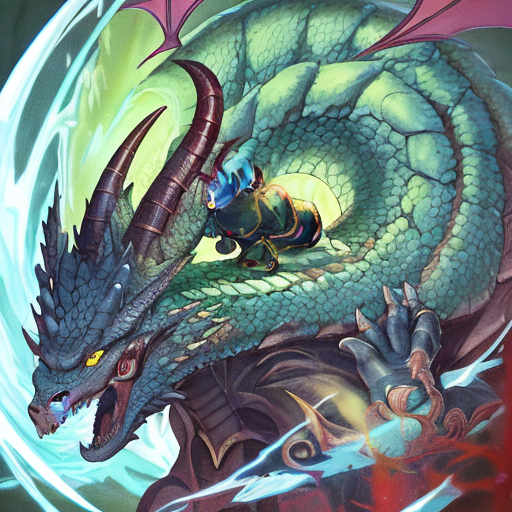

按您的要求画了： a dragon


 exit


退出


In [8]:
chat_with_glm(model,tokenizer,pipe,'你好')

In [7]:
chat_glm_widgets(model,tokenizer,pipe)